In [63]:
import networkx as nx
import numpy as np
from nx_landmarks import landmarks, selection_strategies
from tqdm import tqdm

In [64]:
G = nx.read_adjlist('Data/com-dblp_ungraph.csv')
G = nx.convert_node_labels_to_integers(G)

In [66]:
precomputed = {
    'rand':selection_strategies.random_ranking(G),
    'deg':selection_strategies.degree_ranking(G),
    'close':selection_strategies.closeness_ranking(G, k = 500),
    'between':selection_strategies.betweenness_ranking(G, k = 500),
}
precomputed['iteritave'] = selection_strategies.iterative_sampling(G, ranking=precomputed['between'])

In [156]:
landmarks_arr = [
    landmarks(G,10,['rand'],1, precomputed=precomputed),
    landmarks(G,10, [('deg',(1/3)), ('close',(1/3)), ('between',(1/3))],1, precomputed=precomputed),
    landmarks(G,10, [('close',(1/2)), ('between',(1/2))],1, precomputed=precomputed),
    landmarks(G,10,['deg'],1, precomputed=precomputed),
    landmarks(G,10,['close'],1, precomputed=precomputed),
    landmarks(G,10,['between'],1, precomputed=precomputed),
    landmarks(G,10,['iteritave'],1, precomputed=precomputed)
]
for D in landmarks_arr:
    D.get_landmarks()


In [148]:
def sample_random_pairs(G,n = 1,replace = False):
    choice = np.random.choice(G.nodes(),2*n,replace = replace)
    pairs =[]
    for i in range(n):
        idx = 2*i
        pairs.append(((choice[idx]),choice[idx+1]))
    return pairs

def average_error(D,pairs,true = None):
    if true == None:
        true = [nx.shortest_path_length(G, source=s,target=t) for s,t in pairs]
    estimations = []
    for pair in pairs:
        estimations.append(D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    errors = [(e-t)/t for e,t in zip(estimations,true)]
    return sum(errors)/len(errors)

def LU_ratio_dist(D,pairs):
    ratio = []
    for pair in pairs:
        ratio.append(D.shortest_path_estimation_lower_bound(pair[0],pair[1])/D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    return ratio

In [157]:
def eval_capture_correction(D,samples = 100000):
    good  = 0
    bad = 0
    found = 0 
    for pair in tqdm(sample_random_pairs(G,samples,True)):
        s = pair[0]
        t = pair[1]
        pred_upper = D.shortest_path_estimation_upper_bound(source=s, target=t)
        pred_cap = D.shortest_path_estimation_capture_method(source=s,target=t)
        true = nx.shortest_path_length(G,s,t)
        if pred_cap != pred_upper:
            good += abs(pred_cap-true)
            found += 1
            bad += abs(pred_upper-true)

    print(f'average error capture: {good/found}\naverage error upper bound: {bad/found}')
eval_capture_correction(D = landmarks_arr[3])

100%|██████████| 100000/100000 [00:30<00:00, 3309.50it/s]

average error capture: 0.5384615384615384
average error upper bound: 0.8615384615384616


In [150]:
def experiment_setup(G,landmarks:list)->list:
    
    results_rel_error = [[] for D in landmarks]
    results_lu_ratio = [[] for D in landmarks]
    
    for n_landm in tqdm(range(0,500,10)):
        for idx,D in enumerate(landmarks):
            result_err = []
            for i in range(5):
                result_err.append((average_error(D,sample_random_pairs(G,2000))))
            results_rel_error[idx].append((np.average(np.array(result_err)),len(D.landmarks)))
            D.add_landmarks(10)
    return results_rel_error,results_lu_ratio
results_rel_error,results_lu_ratio = experiment_setup(G,landmarks_arr)

100%|██████████| 50/50 [35:58<00:00, 43.18s/it]


C:\Users\jaspe\AppData\Local\Temp\ipykernel_1696\2785269191.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0)


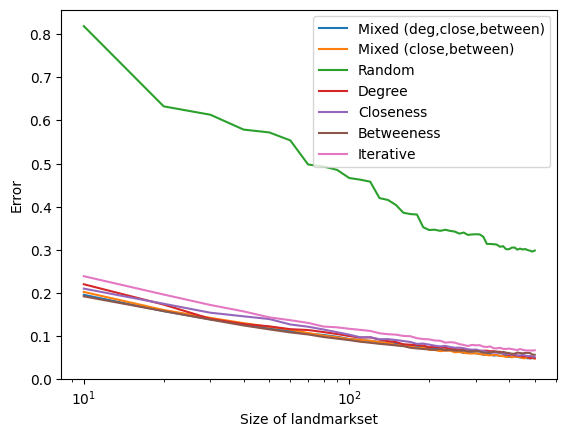

In [151]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
x = [a[1] for a in results_rel_error[1]]
y = [a[0] for a in results_rel_error[1]]
ax.plot(x,y, label = 'Mixed (deg,close,between)')
x = [a[1] for a in results_rel_error[2]]
y = [a[0] for a in results_rel_error[2]]
ax.plot(x,y, label = 'Mixed (close,between)')
x = [a[1] for a in results_rel_error[0]]
y = [a[0] for a in results_rel_error[0]]
ax.plot(x,y, label = 'Random')
x = [a[1] for a in results_rel_error[3]]
y = [a[0] for a in results_rel_error[3]]
ax.plot(x,y, label = 'Degree')
x = [a[1] for a in results_rel_error[4]]
y = [a[0] for a in results_rel_error[4]]
ax.plot(x,y, label = 'Closeness')
x = [a[1] for a in results_rel_error[5]]
y = [a[0] for a in results_rel_error[5]]
ax.plot(x,y, label = 'Betweeness')
x = [a[1] for a in results_rel_error[6]]
y = [a[0] for a in results_rel_error[6]]
ax.plot(x,y, label = 'Iterative')

ax.set_ylabel('Error')
ax.set_xlabel('Size of landmarkset')
ax.set_xscale('log')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
eval_capture_correction(D = landmarks_arr[3])

100%|██████████| 100000/100000 [04:20<00:00, 383.48it/s]

average error capture: 0.7468177855274629
average error upper bound: 0.30688753269398433


In [153]:
import pandas as pd
df = pd.DataFrame(
    [[value for value, _ in row] for row in results_rel_error]
)
df.columns = [f'{(i+1)*10}' for i in range(len(df.columns))]
print(df.loc[:,['20','100','450']].to_latex())

\begin{tabular}{lrrr}
\toprule
 & 20 & 100 & 450 \\
\midrule
0 & 0.632687 & 0.466507 & 0.300749 \\
1 & 0.157663 & 0.093179 & 0.049130 \\
2 & 0.160304 & 0.092845 & 0.048852 \\
3 & 0.172859 & 0.099955 & 0.052726 \\
4 & 0.174780 & 0.103148 & 0.056414 \\
5 & 0.157795 & 0.090468 & 0.059721 \\
6 & 0.196216 & 0.116751 & 0.067974 \\
\bottomrule
\end{tabular}



In [159]:
def experiment_lu_setup(G,landmarks:list)->list:
    
    results_lu_ratio = [[] for D in landmarks]
    
    
    for idx,D in enumerate(landmarks):
        results_lu_ratio[idx].append(LU_ratio_dist(D,sample_random_pairs(G,200000,True)))
    return results_lu_ratio

results_lu_ratio = experiment_lu_setup(G,landmarks_arr)

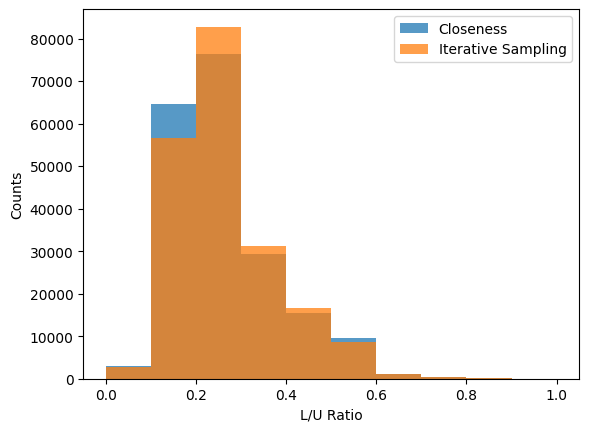

In [160]:
fig,ax = plt.subplots()

ax.hist(results_lu_ratio[4],alpha= 0.75, label='Closeness')
ax.hist(results_lu_ratio[6],alpha= 0.75, label='Iterative Sampling')
ax.set_ylabel('Counts')
ax.set_xlabel('L/U Ratio')
ax.legend()
plt.show()